In [1]:
import os
import shutil
from google.colab import drive

drive.mount('/content/drive')

path_MG = '/content/drive/MyDrive/00gerem00/DL-AI-Project'
path_LM = '/content/drive/MyDrive/lorenzomeroni02/DL-AI-Project'

if os.path.exists(path_MG):
    working_dir = path_MG
    print(f"Working in MG folder: {working_dir}")
elif os.path.exists(path_LM):
    working_dir = path_LM
    print(f"Working in LM folder: {working_dir}")
else:
    print("Error: Project folder not found in Drive. Check the paths.")
    working_dir = None

if working_dir:
    os.chdir(working_dir)
    zip_filename = 'leather-defect-classification.zip'
    fast_local_dir = '/content/fast_dataset'

    if os.path.exists(zip_filename):
        print(f"Great! {zip_filename} found on Drive.")

        if not os.path.exists(fast_local_dir):
            os.makedirs(fast_local_dir, exist_ok=True)
            !unzip -q {zip_filename} -d {fast_local_dir}
    else:
        print(f"Error: {zip_filename} not found in your Drive folder. Please check if you uploaded it correctly to {working_dir}.")

Mounted at /content/drive
Working in MG folder: /content/drive/MyDrive/00gerem00/DL-AI-Project
Great! leather-defect-classification.zip found on Drive.


In [2]:
from torchvision.datasets import ImageFolder

base_dir = '/content/fast_dataset'

content = os.listdir(base_dir)
subfolders = [f for f in content if os.path.isdir(os.path.join(base_dir, f))][0]
data_dir = os.path.join(base_dir, subfolders)

dataset = ImageFolder(
    root = data_dir,
    transform = None)

print(f"Total number of images: {len(dataset)}")
print(f"Classes found: {dataset.classes}")
print(f"Index mapping: {dataset.class_to_idx}")

Total number of images: 3600
Classes found: ['Folding marks', 'Grain off', 'Growth marks', 'loose grains', 'non defective', 'pinhole']
Index mapping: {'Folding marks': 0, 'Grain off': 1, 'Growth marks': 2, 'loose grains': 3, 'non defective': 4, 'pinhole': 5}


In [3]:
from PIL import Image

dataset.samples = [s for s in dataset.samples if Image.open(s[0]).size == (227, 227)]
dataset.imgs = dataset.samples
dataset.targets = [s[1] for s in dataset.samples]
print(f"{len(dataset)} images")

3598 images


# **Model 1: Custom ResNet-18**

## **Data Preprocessing & DataLoader**

First of all, to prepare the dataset for training we decide to split it in train, validation and test set. Specifically, 70% of the data is allocated to the training set. The remaining 30% is divided equally between the validation and test sets. The validation set is actively used at the end of each epoch to monitor the model's generalization capabilities and prevent overfitting, while the test set is kept strictly isolated until the very end. This ensures an completely unbiased final evaluation of the model's accuracy.

In [4]:
import torch
from torch.utils.data import random_split

train_size = int(0.7 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"Completed split: {len(train_set)} training set, {len(val_set)} validation set, {len(test_set)} test set")

Completed split: 2518 training set, 540 validation set, 540 test set


Then we The `TransformSubset` Wrapper is used to apply preprocessing steps after the random dataset splitting. This ensures us to have each set applied the desired transormation without altering the underlying dataset structure.

In [5]:
from torchvision import transforms
from torch.utils.data import Dataset

class TransformSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

The goal of the training pipeline `train_transform` is Data Augmentation to artificially increase the diversity of the training set without collecting new data. In our leather defect classification task, it serves two main purposes:

1. Increasing Variability: It helps the model capture defects from multiple angles and under various lighting conditions, compensating for the fact that the images in our training set (2518) might not cover every real world scenario.
2. Regularization and Preventing Overfitting: By presenting a slightly different version of the same image in each epoch, we prevent the network from "memorizing" specific pixel patterns (noise). Instead, we force it to focus on robust, invariant structural and chromatic features of the defects (*folding marks, pinholes, etc.*).

These are the operations we applied:
* `transforms.Resize((230, 230))`: Starting from original $227 \times 227$ images, we upscale them to $230 \times 230$. Since it is impossible to create new data out of thin air, the system uses bilinear interpolation. The algorithm analyzes the original pixel grid and, as it stretches the image, fills the resulting gaps by calculating a weighted average of adjacent pixels.

* `transforms.RandomCrop((224, 224))`: We randomly cut out a $224 \times 224$ square from the $230 \times 230$ image. This teaches the model spatial invariance. Tt learns to recognize a defect whether it is perfectly in the center or slightly off to the edge.

* `transforms.RandomHorizontalFlip(p=0.5)`: There is a 50% probability the image will be flipped like a mirror. A scratch or a pinhole is still a defect regardless of whether it points left or right.

* `transforms.RandomRotation(15)`: We rotate the image by a random angle between -15 and +15 degrees. This simulates variations in how the camera or the leather might have been positioned on the factory line.

* `transforms.ColorJitter(brightness=0.15, contrast=0.12)`: This randomly alters the lighting. It prevents the model from relying on a specific factory lighting condition, making it robust against brighter or darker environments.

* `transforms.ToTensor()`: It does not merely change the data type. It reshapes the raw image from a spatial format (Height $\times$ Width $\times$ Channels) with pixel intensities in the [0, 255] range, into a PyTorch compatible Tensor (Channels $\times$ Height $\times$ Width), scaling the values down to a [0.0, 1.0] float range for numerical stability.

* `transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])`: It takes the [0.0, 1.0] tensor and applies normalization using a mean and standard deviation of $0.5$ across all three RGB channels.: $z = \frac{x_{c} - 0.5}{0.5}$ . This operation maps the data to an exact [-1.0, 1.0] range. The zero-centered distribution ensures numerical stability and faster gradient convergence during backpropagation.

Moreover, we apply training `mean` and `std` to both validation and test sets, since they must be normalized using the exact empirical mean and standard deviation computed exclusively from the training set. This ensures Feature Space Consistency: the neural network optimizes its weights based on the specific mathematical distribution of the training data; applying different normalization parameters to the test data would shift this distribution and invalidate the model's learned weights.


In [6]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((230, 230)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.15, contrast=0.12),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_final = TransformSubset(train_set, transform=train_transform)
val_final = TransformSubset(val_set, transform=val_test_transform)
test_final = TransformSubset(test_set, transform=val_test_transform)

`DataLoaders` are created, which are essential tools for optimizing the data flow to the neural network. These components manage mini-batching by grouping images into blocks of 32 samples, obtaining gradient stability and computational efficiency.

The shuffle feature is enabled exclusively for the training set, reordering the images at each epoch to prevent the model from memorizing sequences and forcing it to recognize the actual visual patterns of leather defects. Conversely, validation and test data are loaded deterministically and sequentially, ensuring a rigorous evaluation and the accurate generation of the final confusion matrix through data unaltered by stochastic processes.

In [7]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(
    train_final,
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_final,
    batch_size=batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_final,
    batch_size=batch_size,
    shuffle=False
)

To verify the effectiveness of our preprocessing pipeline, we visualized a selection of images before and after applying data augmentation. By comparing the raw leather surfaces with their transformed counterparts, we can observe the impact of the rotation, scaling, and color jittering operations.

This step serves as a visual sanity check to ensure that the transformations introduce sufficient variability to prevent overfitting while preserving the distinctive features of each defect class.

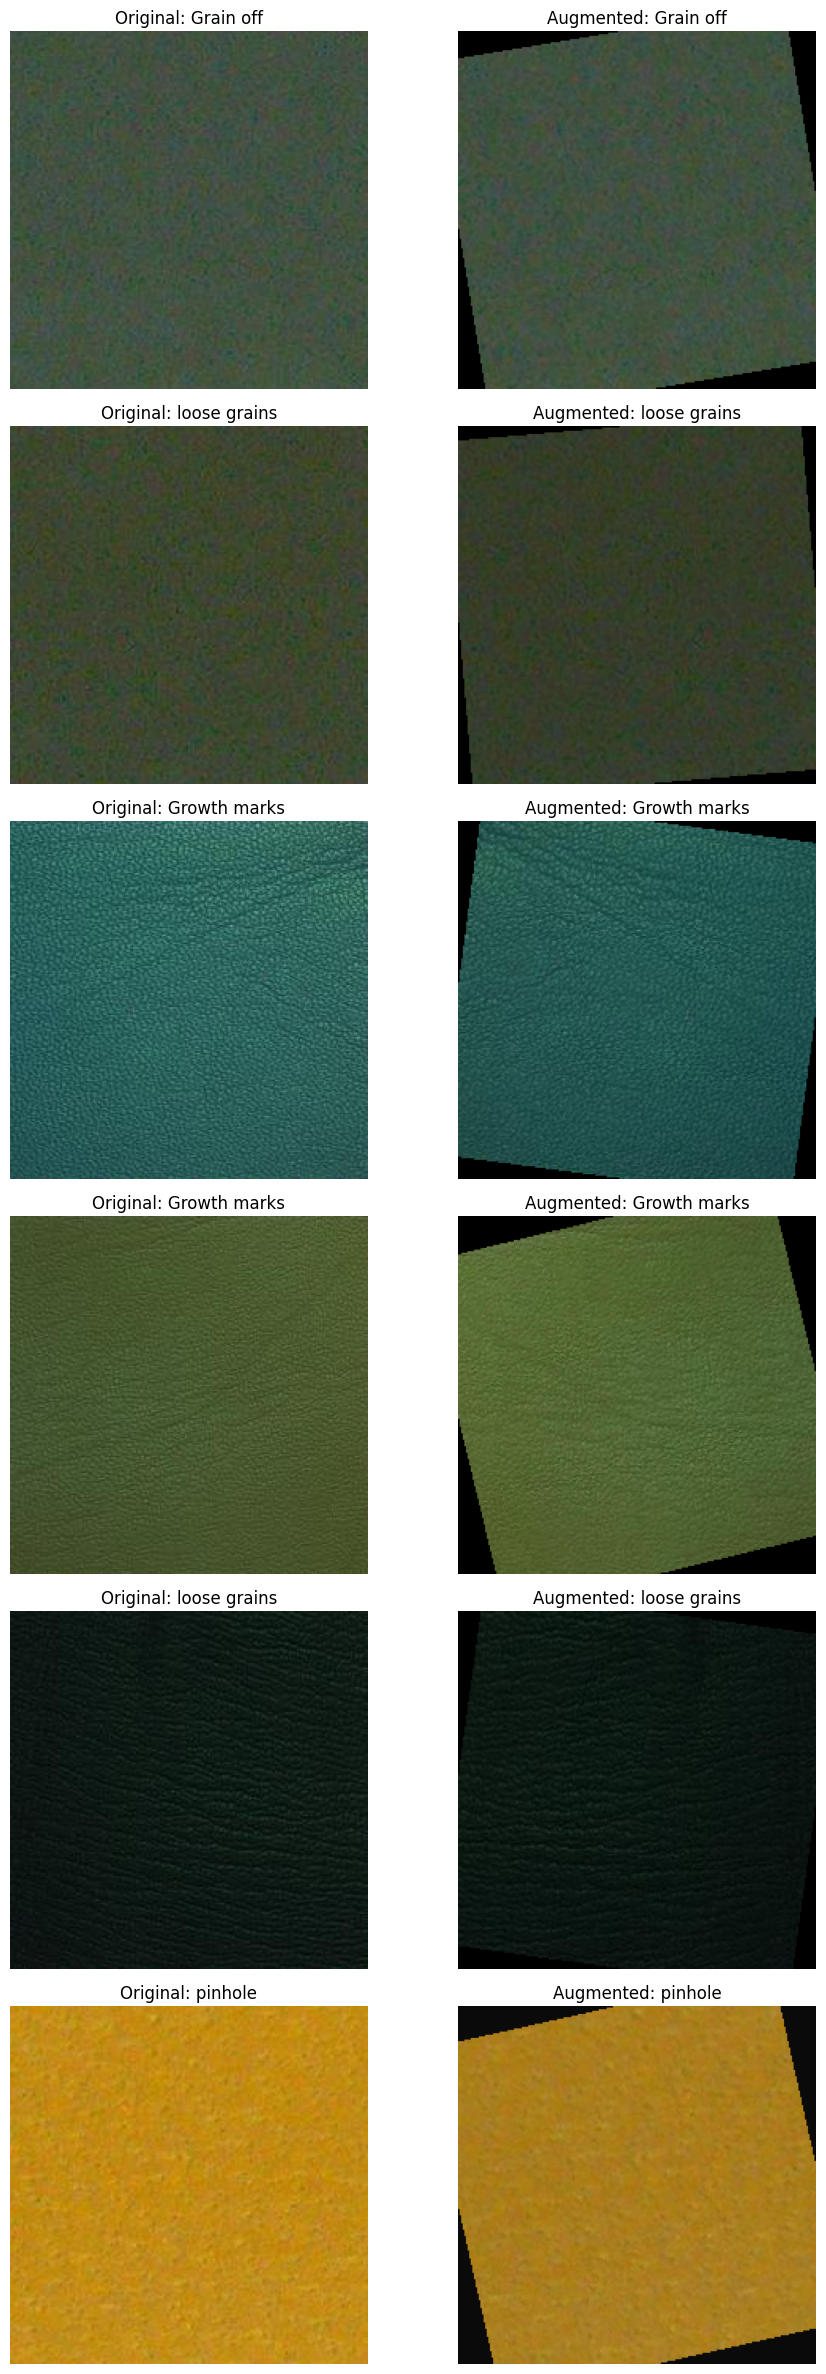

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import random

num_images = 6
random_indices = random.sample(range(len(train_final)), num_images)

fig, axes = plt.subplots(num_images, 2, figsize=(10, 4 * num_images))
fig.suptitle("", fontsize=16)

for i, idx in enumerate(random_indices):
    orig_img, label_idx = train_final.subset[idx]
    aug_tensor, _ = train_final[idx]

    aug_img = aug_tensor / 2 + 0.5
    aug_np = aug_img.numpy()
    aug_np = np.transpose(aug_np, (1, 2, 0))

    label_name = dataset.classes[label_idx]

    axes[i, 0].imshow(orig_img)
    axes[i, 0].set_title(f"Original: {label_name}", fontsize=12)
    axes[i, 0].axis('off')

    axes[i, 1].imshow(aug_np)
    axes[i, 1].set_title(f"Augmented: {label_name}", fontsize=12)
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

## **Model Implementation**

We implement a custom version of ResNet-18, specifically designed for our leather defect classification task. The model follows the residual learning framework introduced by He et al. in *Deep Residual Learning for Image Recognition*, but it is implemented from scratch in PyTorch to maintain full architectural control and adapt it to the specific high-frequency characteristics of our dataset.

As originally proposed, ResNet reformulates the learning objective so that stacked layers approximate a residual function $F(x) := H(x) - x$, allowing the network to learn mappings of the form $H(x) = F(x) + x$ through identity shortcut connections.

These shortcuts fundamentally address the vanishing gradient problem observed in very deep plain networks. During backpropagation, the gradient can flow directly and unaltered through the identity connection ($+x$), reaching shallower layers without being diminished by deep matrix multiplications. Furthermore, if the network determines that the input $x$ is already optimal for a certain level of abstraction, the optimizer can simply push the weights of $F(x)$ toward zero, naturally collapsing $H(x)$ into an identity mapping.

Building upon this mathematical principle, our implementation preserves the core residual structure while introducing critical task-specific adaptations aimed at improving performance on fine-grained leather surface defects.

#### **Residual Block (`BasicBlock`)**

Each residual block consists of:

* Two $3 \times 3$ convolutional layers;
* Batch Normalization after each convolution;
* ReLU activation;
* An identity shortcut connection.

If the spatial resolution or the number of channels changes (i.e., when `stride != 1` or `in_channels != out_channels`), the shortcut path is adjusted using a $1 \times 1$ linear projection (convolution) followed by Batch Normalization. This ensures the identity tensor $x$ is properly resized and dimensionally aligned for the element-wise addition $F(x) + x$.

#### **Network Architecture (`CustomResNet18`)**

The overall architecture follows the canonical ResNet-18 configuration, but with a fundamental modification at the stem:

**Initial Convolutional Layer and Max-Pooling Omission**

The network's entry point consists of a $7 \times 7$ convolutional operation configured with 64 output channels, a stride of 2, and a padding of 3. This is immediately followed by Batch Normalization and a Rectified Linear Unit (ReLU) activation. Crucially, unlike the original ResNet-18, the initial Max-Pooling layer has been intentionally omitted.

This is a deliberate, domain-specific design choice. Given input tensors with spatial dimensions of $224 \times 224$ pixels, the first strided convolution reduces the feature map resolution to $112 \times 112$. In a standard ResNet, a subsequent Max-Pooling operator would aggressively downsample this representation to $56 \times 56$. Because leather defects, such as *pinholes* or subtle *folding marks*, manifest as high-frequency spatial gradients occupying a minuscule pixel area, Max-Pooling would inadvertently act as a severe low-pass filter, erasing these critical micro-structures into the background noise. By bypassing this pooling step, our `CustomResNet18` propagates a highly detailed $112 \times 112$ receptive grid into the first residual stage, ensuring the network preserves and specializes in fine-grained textural anomalies.

Following the theoretical foundations of the ResNet architecture, our `CustomResNet18` implementation is structured into four distinct residual stages. The design carefully manages spatial downsampling, channel expansion, and gradient flow to ensure robust feature extraction.

**Residual Layers**

The core feature extraction is driven by four sequential modules (`self.layer1` through `self.layer4`).

* The initial module (`layer1`) processes the feature maps while maintaining the input and output spatial dimensions.
* To manage computational complexity and increase the receptive field, the subsequent three modules introduce spatial reduction. Dimensionality reduction is achieved using a downsample per module approach rather than relying on pooling layers. By applying `stride=2` to the first block of `layer2`, `layer3`, and `layer4` via the `_make_layer` function, the network effectively halves the spatial resolution while simultaneously doubling the channel depth (progressing from 64 to 128, 256, and finally 512 channels).

To guarantee unimpeded gradient flow during backpropagation and mitigate the vanishing gradient problem, the underlying `BasicBlock` evaluates the residual mapping ($f(x) = g(x) + x$) using two distinct types of skip connections:

* Identity Shortcut: When the input and output dimensions are mathematically identical, a simple, parameter-free skip connection ($+x$) is applied. This is utilized throughout `layer1` and in all secondary blocks of the deeper stages.
* Projection Shortcut ($1 \times 1$ Convolution): When tensor dimensions change across stages, specifically when halving the spatial resolution and doubling the channels, the shapes must be aligned before the element-wise addition. By passing the `stride` variable dynamically within the `_make_layer` loop, our implementation triggers a $1 \times 1$ convolutional projection exclusively when necessary, ensuring dimensional consistency without unnecessarily inflating the parameter count.

**Global Feature Aggregation**

After the final residual stage, the `nn.AdaptiveAvgPool2d((1, 1))` reduces the spatial dimensions to $1 \times 1$, independently of the incoming feature map size.
This provides extreme architectural flexibility and acts as a strong regularizer. It collapses the 512 spatial feature maps into a single 512-dimensional vector, effectively summarizing the global presence of learned features regardless of their exact spatial location on the leather sample.

**Classification Head**

The final classifier consists of a single fully connected layer: `Linear(512 → 6)`, where 6 corresponds to the number of mutually exclusive leather defect classes. Consistent with the canonical ResNet-18, we avoid complex bottleneck blocks, relying entirely on the expressive power of the BasicBlocks.

In summary, our main architectural choices are:

1. Residual learning to stabilize deep training and ensure healthy gradient flow.
2. Intentional removal of the initial max-pooling layer to prevent the loss of high-frequency spatial details crucial for fine-grained texture analysis.
3. Learned spatial downsampling coupled with progressive channel expansion (64 → 128 → 256 → 512) to extract abstract semantic features without relying on destructive pooling operations.
4. Adaptive average pooling to achieve spatial invariance and mitigate overfitting prior to classification.
5. A streamlined fully connected head for direct and robust multiclass prediction.

This implementation provides a strong and interpretable baseline model tailored for industrial leather defect classification, maintaining architectural transparency and full control over the training dynamics.

In [9]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        # We use a 3x3 convolution. If stride > 1, this layer handles spatial downsampling.
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # The second convolution completes the residual function F(x).
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # The shortcut connection represents the identity mapping 'x'.
        self.shortcut = nn.Sequential()

        # If spatial dimensions shrink or channel depth increases,
        # we apply a 1x1 linear projection to align the tensor dimensions
        # before the elementwise addition.
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        # We store the original input to bypass the convolutional layers.
        identity = self.shortcut(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        # This is the mathematical heart of the block: H(x) = F(x) + x
        out += identity
        out = self.relu(out)
        return out


class CustomResNet18(nn.Module):
    def __init__(self, num_classes=6):
        super(CustomResNet18, self).__init__()
        self.in_channels = 64

        # We use a 7x7 kernel to capture broad initial features.
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # as we progress, spatial resolution is halved (stride=2),
        # while feature channels are doubled (64 -> 128 -> 256 -> 512).
        self.layer1 = self._make_layer(64, num_blocks=2, stride=1)
        self.layer2 = self._make_layer(128, num_blocks=2, stride=2)
        self.layer3 = self._make_layer(256, num_blocks=2, stride=2)
        self.layer4 = self._make_layer(512, num_blocks=2, stride=2)

        # Adaptive pooling provides spatial invariance. It ensures the classifier
        # always receives a 512 dimensional vector, regardless of the intermediate tensor shapes.
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Final fully connected layer mapping directly to our 6 mutually exclusive classes.
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(BasicBlock(self.in_channels, out_channels, stride=s))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        # Flowing through the residual layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Global aggregation and final classification
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

## **Weight Initialization and Non-Linear Activation**

The proper initialization of convolutional filters and the choice of activation functions are critically intertwined in deep neural networks to prevent the vanishing and exploding gradient problems. In our architecture, we establish a precise mathematical pairing between the Kaiming (He) initialization and the Rectified Linear Unit (ReLU) activation.

To introduce the necessary nonlinearities, we employ the ReLU activation, mathematically defined as:

$$f(x) = \max(0, x)$$

The use of ReLU, however, introduces a statistical challenge. Because ReLU is heavily asymmetric and completely zeros out all negative input values, it effectively eliminates 50% of the signal's variance (assuming the inputs to the layer are distributed symmetrically around zero). If standard initialization techniques were used, the variance of the activations would be halved at each layer, exponentially decaying to zero and stalling the learning process.

To compensate for this 50% variance loss, the network utilizes Kaiming (He) initialization, which mathematically proves that the variance of the initial weights must be doubled to stabilize the signal.
Let $W$ represent the weight tensor of a convolutional layer, and let $n_{\text{in}}$ (often referred to as *fan-in*) denote the number of input connections to a given neuron (calculated as $\text{input_channels} \times \text{kernel_height} \times \text{kernel_width}$). To maintain a stable variance across the deep residual blocks, the variance of the weights is defined as:


$$\text{Var}(W) = \frac{2}{n_{\text{in}}}$$

Consequently, PyTorch initializes the `nn.Conv2d` layers by drawing weights from a distribution parameterized by this variance. While a zero-mean Normal distribution $\mathcal{N}\left(0, \frac{2}{n_{\text{in}}}\right)$ can be used, the default implementation samples the weights $W$ from a bounded Uniform distribution $\mathcal{U}(-a, a)$, where the bound $a$ is explicitly derived to yield the exact same variance:


$$a = \sqrt{\frac{6}{n_{\text{in}}}} \implies W \sim \mathcal{U}(-a, a)$$

This rigorous mathematical formulation ensures that when the feature maps pass through the convolutional filters and the subsequent ReLU activations within our `BasicBlock` modules, the scale of the forward activations and backward gradients remains strictly stable, enabling robust and efficient convergence.

# **Setting the GPU**

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device in uso: {device}")

model = CustomResNet18(num_classes=6)

model = model.to(device)

Device in uso: cpu


## **Model Training**

To train our `CustomResNet18`, we designed a comprehensive training pipeline focused on robust convergence, hyperparameter optimization, and overfitting mitigation. The optimization process is driven by the Adam optimizer and is heavily regulated by a dynamic learning rate scheduler and an early stopping mechanism.

### **Optimization Strategy**

To optimize the training process of our Custom ResNet-18, we performed a systematic Grid Search over different initial learning rates to identify the configuration yielding the peak validation performance. Specifically, we evaluated four candidate values:


$$\eta_{init} \in \{10^{-3}, 5 \times 10^{-4}, 10^{-4}, 10^{-5}\}$$

For each configuration, the model was trained for a maximum of 80 epochs. The best model was selected based on the lowest validation loss achieved across all grid search runs ($\theta^{*} = \text{argmin}_{\theta \in \text{all runs}} \mathcal{L}_{val}(\theta)$).

**Adam Optimizer and Learning Rate Scheduler**

The core of our optimization strategy is the Adam (Adaptive Moment Estimation) optimizer. Adam is particularly appropriate for deep networks because it calculates adaptive learning rates for each individual parameter by maintaining two moving averages: the first moment $m_t$ (the mean of gradients) and the second moment $v_t$ (the uncentered variance).

The parameter update at step $t$ is defined as:


$$\theta_{t+1} = \theta_{t} - \frac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t$$

While Adam manages per-parameter adaptation, we integrated a *ReduceLROnPlateau* scheduler to manage the global learning rate boundary. The scheduler monitors the validation loss with a `patience = 3`: if no improvement is observed for three consecutive epochs, the global learning rate $\eta$ is decayed by a `factor = 0.1`:


$$\eta_{new} = 0.1 \cdot \eta_{current}$$

This synergy is vital: while Adam handles the internal balancing of gradients, the scheduler informs Adam when it is time to reduce the global speed. By lowering $\eta$, we allow the optimizer to perform finer, more precise updates in the proximity of the local minimum, preventing the model from overshooting or oscillating around the optimal solution.

**Early Stopping**

Directly linked to our scheduling strategy is the Early Stopping mechanism. To prevent overfitting and avoid unnecessary computation, we set an Early Stopping threshold with a `patience = 10`.

If the validation loss fails to reach a new minimum for ten consecutive epochs, even after the scheduler has attempted to refine the search by reducing the learning rate training is forcefully interrupted. This ensures that the weights saved correspond to the peak generalization capability of the network rather than an overfitted state where the model has simply memorized the training distribution.

**Cross-Entropy Loss**

To guide the optimization process, we adopt Cross-Entropy Loss. Since our task is a six class classification problem where categories are mutually exclusive, the network outputs raw logits $z_i$, which are transformed into a probability distribution $p_i$ via the Softmax function:


$$p_i = \frac{e^{z_i}}{\sum_{j=1}^{6} e^{z_j}}$$

The loss for a single sample is defined as:


$$\mathcal{L} = -\sum_{i=1}^{6} y_i \log(p_i)$$

This formulation is particularly effective for our leather defect dataset for two main reasons:

* It strongly penalizes confident misclassifications. If the model assigns a high probability to the wrong class, the loss increases exponentially, forcing the model to adjust its decision boundaries.

* Minimizing this loss is fundamentally equivalent to minimizing the divergence between the predicted probability distribution and the true distribution of the labels. This ensures that the model learns to produce sharper and more reliable predictions, which is crucial for distinguishing subtle texture variations.

**Monitoring**

For each configuration, we recorded:

* Training Loss;
* Training Accuracy;
* Validation Loss;
* Validation Accuracy;
* Learning Rate Evolution;
* Epoch Duration.

This comprehensive monitoring allowed us to analyze both optimization dynamics and generalization behavior across different learning rates.

At the end of the process, the combination with the lowest validation loss is selected as the optimal configuration. The corresponding model parameters are stored, along with the validation losses for all tested configurations, enabling further analysis on learning rate hyperparameter behaviour and on model evaluation.

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import copy
import os
import json

In [ ]:
REPO_PATH = '/content/drive/MyDrive/00gerem00/DL-AI-Project/'
SAVE_DIR = os.path.join(REPO_PATH, 'models_best')
os.makedirs(SAVE_DIR, exist_ok=True)

lr_values = [1e-3, 5e-4, 1e-4, 1e-5]

num_epochs = 80
patience_es = 10
patience_sched = 3

global_best_loss = float("inf")
global_best_lr = None
global_best_model_state = None

results_summary = {}
full_histories = {}

print(f"Save directory: {SAVE_DIR}")
print("STARTING GRID SEARCH WITH FULL MONITORING (LOSS, ACCURACY, LR, TIME)")

for initial_lr in lr_values:
    print("\n" + "="*70)
    print(f"TESTING INITIAL LEARNING RATE: {initial_lr}")
    print("="*70)

    model = CustomResNet18(num_classes=6).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=initial_lr)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience_sched)

    counter_es = 0
    best_val_loss_current = float("inf")

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'lr_evolution': [], 'epoch_duration': []
    }

    for epoch in range(num_epochs):
        start_time = time.time()

        # Track current Learning Rate before the step
        current_lr = optimizer.param_groups[0]['lr']
        history['lr_evolution'].append(current_lr)

        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / total_train
        train_acc = correct_train / total_train

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = val_loss / total_val
        val_acc = correct_val / total_val

        scheduler.step(val_loss)

        duration = time.time() - start_time
        history['epoch_duration'].append(duration)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1:2d}/{num_epochs}] - Time: {duration:.0f}s - LR: {current_lr:.6f}")
        print(f"  Train -> Loss: {train_loss:.4f} | Accuracy: {train_acc*100:.2f}%")
        print(f"  Val   -> Loss: {val_loss:.4f} | Accuracy: {val_acc*100:.2f}%")
        print("-" * 30)

        if val_loss < best_val_loss_current:
            best_val_loss_current = val_loss
            counter_es = 0
            if val_loss < global_best_loss:
                global_best_loss = val_loss
                global_best_lr = initial_lr
                global_best_model_state = copy.deepcopy(model.state_dict())
                print(f"   *** NEW GLOBAL RECORD! Best Val Loss: {global_best_loss:.4f} ***")
        else:
            counter_es += 1
            if counter_es >= patience_es:
                print(f"Early Stopping triggered at epoch {epoch+1}.")
                break

    results_summary[f"Initial_LR_{initial_lr}"] = {
        'best_val_loss': best_val_loss_current,
        'final_accuracy': val_acc
    }
    full_histories[f"Initial_LR_{initial_lr}"] = history


best_model_path = os.path.join(SAVE_DIR, "RESNET18_GLOBAL_BEST.pth")
torch.save(global_best_model_state, best_model_path)

summary_json_path = os.path.join(SAVE_DIR, "grid_search_summary.json")
with open(summary_json_path, "w") as f:
    json.dump(results_summary, f, indent=4)

full_logs_json_path = os.path.join(SAVE_DIR, "full_training_logs.json")
with open(full_logs_json_path, "w") as f:
    json.dump(full_histories, f, indent=4)

print("\nGRID SEARCH FINISHED")
print(f"Winning Initial LR: {global_best_lr}")
print(f"Global Best Loss: {global_best_loss:.4f}")
print(f"All files saved in: {SAVE_DIR}")

Save directory: /content/drive/MyDrive/00gerem00/DL-AI-Project/models_best
STARTING GRID SEARCH WITH FULL MONITORING (LOSS, ACCURACY, LR, TIME)

TESTING INITIAL LEARNING RATE: 0.001
Epoch [ 1/80] - Time: 40s - LR: 0.001000
  Train -> Loss: 1.3584 | Accuracy: 44.80%
  Val   -> Loss: 1.0623 | Accuracy: 59.44%
------------------------------
   *** NEW GLOBAL RECORD! Best Val Loss: 1.0623 ***
Epoch [ 2/80] - Time: 39s - LR: 0.001000
  Train -> Loss: 1.1025 | Accuracy: 52.58%
  Val   -> Loss: 0.8413 | Accuracy: 65.00%
------------------------------
   *** NEW GLOBAL RECORD! Best Val Loss: 0.8413 ***
Epoch [ 3/80] - Time: 39s - LR: 0.001000
  Train -> Loss: 1.1090 | Accuracy: 52.50%
  Val   -> Loss: 0.9301 | Accuracy: 59.44%
------------------------------
Epoch [ 4/80] - Time: 39s - LR: 0.001000
  Train -> Loss: 1.0277 | Accuracy: 54.01%
  Val   -> Loss: 0.8358 | Accuracy: 63.52%
------------------------------
   *** NEW GLOBAL RECORD! Best Val Loss: 0.8358 ***
Epoch [ 5/80] - Time: 39s - LR

*Thanks to the following lines of code we load the best model's training logs and previously saved optimal weights onto the current device*.

In [14]:
base_path = '/content/drive/MyDrive/00gerem00/DL-AI-Project/models_best/'

with open(base_path + 'full_training_logs.json', 'r') as f:
    full_histories = json.load(f)

with open(base_path + 'grid_search_summary.json', 'r') as f:
    summary = json.load(f)

best_lr_key = "Initial_LR_0.0001"
history = full_histories[best_lr_key]

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomResNet18(num_classes=6)
model.load_state_dict(torch.load(base_path + 'RESNET18_GLOBAL_BEST.pth',
                                 map_location=device))
model = model.to(device)
model.eval()

CustomResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), s

## **Best Model**

Following the Grid Search procedure over different initial learning rates, the best-performing configuration was identified as the model trained with an Initial Learning Rate of $10^{-4}$. The model selection criterion was strictly based on minimizing the validation loss to ensure well-calibrated confidence in predictions.

Under this configuration, the saved model achieved the lowest Validation Loss of $0.2420$, with a corresponding Validation Accuracy of $92.04\%$. It is worth noting that while the network reached a peak validation accuracy of $92.96\%$ at epoch 46, the model weights were selected based on the epoch with the minimum loss. This guarantees that the final model possesses the most robust and well calibrated decision boundaries, rather than simply maximizing raw accuracy at the expense of overconfident misclassifications.

In comparison, higher learning rates such as $10^{-3}$ and $5 \times 10^{-4}$ converged faster in the early stages but stabilized at higher minimum validation losses ($0.3061$ and $0.3003$ respectively). This indicates less precise optimization, as the larger step sizes likely caused the optimizer to oscillate around the minimum. Conversely, the smallest learning rate ($10^{-5}$) produced very stable training but resulted in a slightly higher validation loss ($0.2526$), suggesting an inability to effectively escape suboptimal regions to fine-tune the feature representations.

Overall, the learning rate of $10^{-4}$ provided the optimal balance between convergence speed and generalization performance. Consequently, its corresponding weights, saved strictly at the epoch of minimum validation loss, were selected as the definitive global model for all subsequent evaluations.

## **Training Dynamics**

Before evaluating our model on unseen data, we retrospectively analyze the training dynamics of the selected configuration (Initial Learning Rate = $10^{-4}$) by visualizing the evolution of training and validation loss, training and validation accuracy, and the learning rate schedule across epochs.

These plots allow us to verify the convergence behavior and confirm the absence of overfitting. Furthermore, they highlight the effectiveness of the `ReduceLROnPlateau` scheduler, which dynamically refined the optimization process by reducing the step size when the validation loss plateaued, enabling the model to settle into an optimal local minimum.

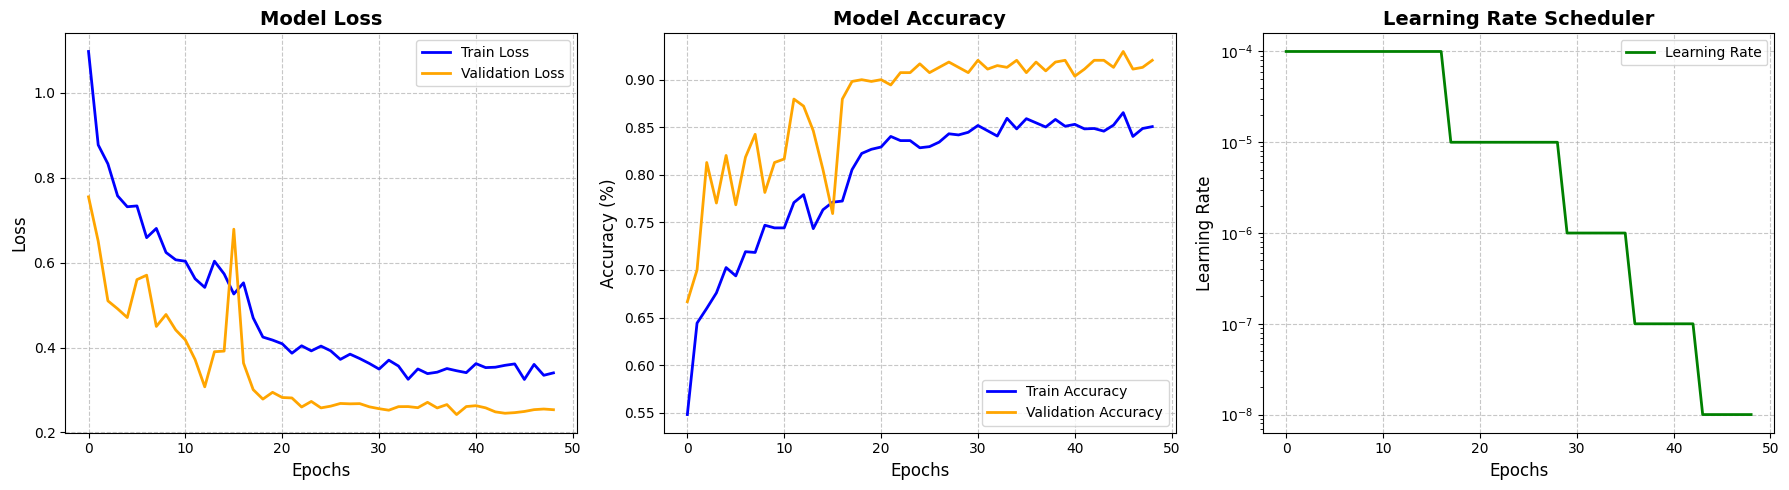

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

best_lr_key = "Initial_LR_0.0001"
history = full_histories[best_lr_key]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

ax1.plot(history['train_loss'], label='Train Loss', color='blue', linewidth=2)
ax1.plot(history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
ax1.set_title('Model Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.7)

ax1_epochs = range(len(history['train_acc']))
ax2.plot(history['train_acc'], label='Train Accuracy', color='blue', linewidth=2)
ax2.plot(history['val_acc'], label='Validation Accuracy', color='orange', linewidth=2)
ax2.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.7)

ax3.plot(history['lr_evolution'], label='Learning Rate', color='green', linewidth=2)
ax3.set_title('Learning Rate Scheduler', fontsize=14, fontweight='bold')
ax3.set_xlabel('Epochs', fontsize=12)
ax3.set_ylabel('Learning Rate', fontsize=12)
ax3.set_yscale('log')
ax3.legend()
ax3.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

The three subplots above illustrate the optimization trajectory of the best performing `CustomResNet18` configuration across 49 epochs of training. The graphs collectively demonstrate a well-controlled learning process, characterized by stable convergence and effective hyperparameter scheduling.

**1. Model Loss Evaluation**

The left plot (Model Loss) highlights the network's learning efficiency. During the initial 15 epochs, both training and validation losses drop steeply, indicating that the model is rapidly learning the fundamental structural features of the different leather defects. Crucially, the validation loss closely tracks the training loss without diverging upward, which suggests that the implicit regularization provided by Batch Normalization successfully prevents early overfitting.

The absolute minimum validation loss ($0.2420$) is achieved at epoch 39. Beyond this point, the validation loss begins to subtly oscillate and increase slightly, while the training loss continues its slow descent. This decoupling marks the onset of mild overfitting, which is correctly identified and halted by the Early Stopping mechanism at epoch 49.

**2. Model Accuracy Progression**

The center plot (Model Accuracy) mirrors the loss dynamics but focuses on classification correctness. The validation accuracy rises sharply in the first 10 epochs, quickly surpassing the 80% threshold. The curves demonstrate high stability, lacking the severe spikes or drops that typically characterize an excessively high learning rate. While the model reaches a peak validation accuracy of $92.96\%$ at epoch 46, the weights were intentionally saved at epoch 39 (corresponding to the minimum loss) to prioritize well-calibrated class probabilities over slightly overconfident, localized accuracy gains.
Notably, the accuracy curves are characterized by low volatility, confirming that the batch size and learning rate were well-balanced for the complexity of the 6 class leather defect dataset.

**3. Impact of the Learning Rate Scheduler**

The right plot (Learning Rate Scheduler) visualizes the active interventions of the `ReduceLROnPlateau` algorithm. Starting at $\eta = 10^{-4}$, the scheduler detects optimization plateaus and triggers step-wise reductions (factor = 0.1) at key intervals (epochs 18, 30, 37, and 44).
The log-scale visualization shows that the training concluded with a learning rate in the magnitude of $10^{-8}$, indicating that the model reached a highly stable convergence point before the early stopping or epoch limit was reached.
By cross-referencing this plot with the Loss and Accuracy graphs, the synergy between Adam and the scheduler becomes evident:

* The first decay at epoch 18 allows the model to escape a temporary stagnation, prompting a renewed, gentle descent in the validation loss.
* Subsequent decays precisely control the optimizer's step size, enabling the network to micro-tune the feature weights and settle safely into the deepest region of the local minimum at epoch 39.

The synergy between the model architecture and the dynamic learning rate adjustment resulted in a highly performant classifier.

# **Test Evaluation**

Having confirmed the stability of the training process by analyzing the Training Dynamics, we now proceed with a comprehensive evaluation of the final model. To ensure a strictly unbiased assessment of the network's real-world generalization capabilities, all subsequent metrics and qualitative analyses are computed exclusively on the unseen test set, which was never exposed to the network during training or hyperparameter tuning.

The evaluation process is structured in three complementary steps:

* First, we performed inference strictly on the **test set** to obtain predicted labels and compared them with ground truth annotations. This enabled us to compute a **Confusion Matrix**, providing a detailed view of class-wise performance and highlighting potential misclassification patterns among visually similar defect categories on completely new data.
* Second, we generated a **Classification Report**, including precision, recall, and F1-score for each of the six classes. This step is crucial in our fine-grained leather defect classification task, as it allows us to evaluate whether the model performs consistently across all defect types in a simulated real-world scenario, rather than relying solely on global accuracy.
* Finally, we produced a qualitative **Inference Gallery**, displaying a random subset of test images along with their predicted and true labels. This visual inspection complements the quantitative metrics by offering an intuitive understanding of the model’s strengths and remaining weaknesses, particularly in visually ambiguous cases.

Together, these analyses provide a thorough evaluation of the implemented ResNet-18 model, combining class-level performance assessment and qualitative inspection of predictions on strictly unseen data.

## **Confusion Matrix**

100%|██████████| 17/17 [03:17<00:00, 11.64s/it]


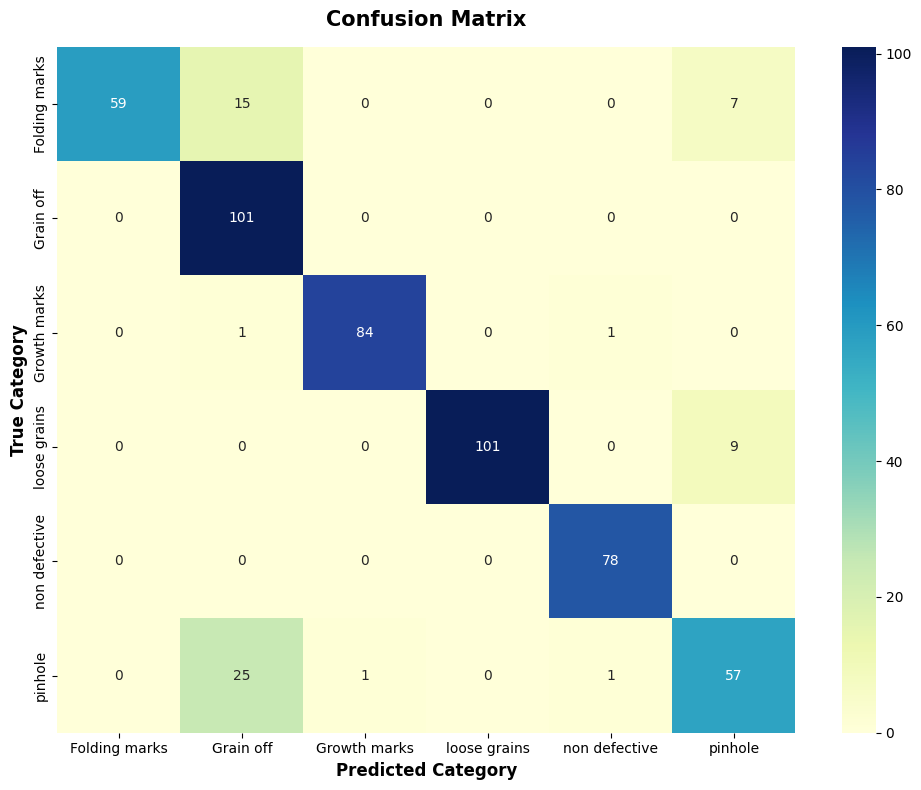

In [19]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

class_names = dataset.classes

def confusionmat(y_true, y_pred, classes):

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))

    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
                xticklabels=classes, yticklabels=classes)

    plt.title('Confusion Matrix', fontsize=15, fontweight='bold', pad=15)
    plt.ylabel('True Category', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted Category', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

confusionmat(all_labels, all_preds, class_names)

The visual distribution of predictions within the Confusion Matrix reveals a highly robust model with a strongly populated diagonal, confirming that the network has successfully learned discriminative feature representations for the majority of the dataset on the unseen test set.

* High-Performing Classes: The model exhibits exceptional reliability on the *Grain off* and *Non defective* classes, achieving perfect recognition (101/101 and 78/78, respectively) with zero false negatives. Similarly, *Growth marks* (84/86) and *Loose grains* (101/110) are classified with high accuracy, demonstrating the architecture's capability to capture their distinct structural patterns.

* Areas of Textural Overlap: The misclassifications are not randomly distributed but are logically concentrated. The network primarily struggles with *Pinholes* (25 misclassified as *Grain off*) and *Folding marks* (15 misclassified as *Grain off* and 7 as *Pinhole*). Additionally, a minor overlap is observed where 9 samples of *Loose grains* were predicted as *Pinhole*. This behavior is morphologically coherent: dense clusters of tiny puncture marks (*Pinholes*) or sharp, localized creases (*Folding marks*) can present high-frequency spatial gradients that closely mimic the roughened, eroded surface typical of a *Grain off* defect.

Overall, the matrix indicates a logically sound optimization where errors occur almost exclusively between classes sharing significant visual and textural overlap.

## **Classification Report**

In [28]:
import pandas as pd

report_dict = classification_report(all_labels, all_preds,
                                    target_names=class_names, output_dict=True)
accuracy_val = report_dict.pop('accuracy')
df_report = pd.DataFrame(report_dict).transpose()
df_report['support'] = df_report['support'].astype(int)

Report = (
    df_report.style
    .set_caption("Classification Report")
    .format({
        'precision': '{:.2f}',
        'recall': '{:.2f}',
        'f1-score': '{:.2f}',
        'support': '{:d}'
    })
    .background_gradient(cmap='YlGnBu', subset=['precision', 'recall', 'f1-score'],
                         vmin=0.0, vmax=1.0)
    .set_table_styles([{
        'selector': 'caption',
        'props': [('color', 'black'), ('font-size', '16px'), ('font-weight', 'bold')]
    }])
)

print(f"Global Accuracy: {accuracy_val:.2%}\n")
Report

Global Accuracy: 88.89%



The model achieved a Global Accuracy of $88.89\%$ on the unseen test set. However, relying solely on global accuracy can be misleading in multi-class scenarios, especially when dealing with complex textural overlaps. Therefore, we computed the Precision, Recall, and F1-score for each category to evaluate the model's behavior on a per-class basis.

These metrics are derived from the True Positives (TP), False Positives (FP), and False Negatives (FN) extracted from the Confusion Matrix:

* Precision: Defined as $\frac{TP}{TP + FP}$. It measures the model's exactness. A high precision means that when the model predicts a specific defect, it is highly likely to be correct.
* Recall: Defined as $\frac{TP}{TP + FN}$. It measures the model's completeness. A high recall means the model successfully identified the majority of the true instances of a specific defect.
* F1-Score: Defined as the harmonic mean of Precision and Recall: $2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$. It provides a single, balanced metric that penalizes extreme disparities between Precision and Recall, making it the most robust indicator of a model's true performance.

The model demonstrates exceptional classification capabilities for *Growth marks*, *Loose grains*, and *Non defective* samples, all of which achieved an excellent F1-score ranging between $0.96$ and $0.99$.
Particularly noteworthy is the *Non defective* class, which achieved a perfect Recall of $1.00$ and a high Precision of $0.98$. This means the system successfully identified $100\%$ of the healthy leather samples (zero false negatives) while making almost no false alarms.

The metrics also perfectly encapsulate the visual confusion observed in the Confusion Matrix regarding the *Grain off*, *Folding marks*, and *Pinhole* classes:

* *Grain off*: This class achieved a perfect Recall ($1.00$), meaning the model successfully found every single actual *Grain off* defect. However, its Precision drops to $0.71$. This happens because the model over-predicts this class, absorbing the False Positives generated by misclassified *Folding marks* and *Pinholes*.
* *Folding marks*: Conversely, the *Folding marks* class exhibits a perfect Precision ($1.00$) but a noticeably lower Recall ($0.73$). This means that when the model explicitly predicts a *Folding mark*, it is absolutely correct ($100\%$ of the time). The lower recall is caused by the model missing several of these defects, erroneously classifying them under the visually similar, broader *Grain off* category.
* *Pinhole*: The *Pinhole* class proved to be the most challenging anomaly, recording a Precision of $0.78$ and a Recall of $0.68$. Rather than a generic distribution of errors, the misclassifications are highly specific. The lower recall is driven by $25$ actual *Pinhole* samples being misclassified as *Grain off*, as dense clusters of tiny puncture marks closely mimic the roughened, eroded surface of a grain off defect. Conversely, the drop in Precision is caused by the model incorrectly predicting *Pinhole* on $7$ *Folding marks* and $9$ *Loose grains* samples. In these cases, sharp localized creases or the natural wrinkles of relaxed skin likely cast point like shadows that the convolutional filters misinterpret as actual holes.

The overall Macro and Weighted F1-scores both stand at $0.89$, confirming that the model's performance is not artificially inflated by a single dominant class but remains highly balanced and effective across the dataset, even on strictly unseen data. The isolated drop in F1-scores for *Folding marks* ($0.84$), *Grain off* ($0.83$), and specifically *Pinhole* ($0.73$) is geometrically bounded and logically consistent with the severe textural overlap of these specific anomalies.

## **Inference Gallery**

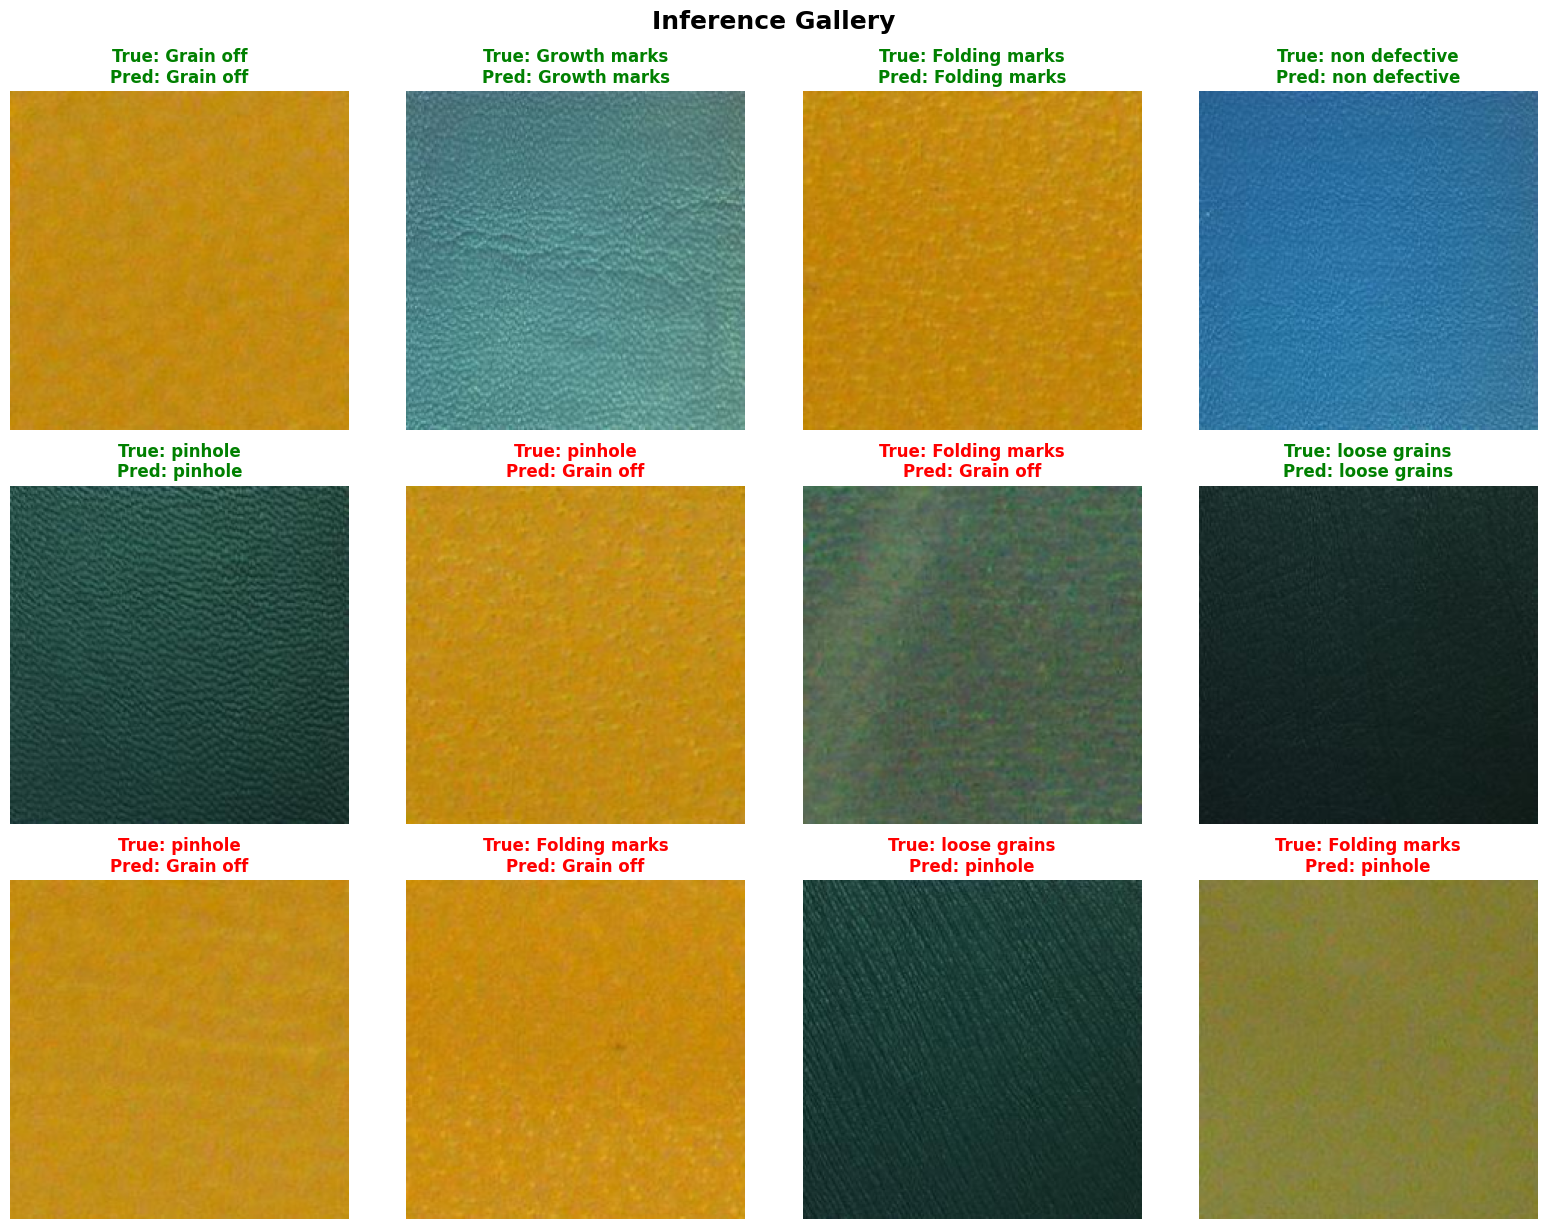

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Set model to evaluation mode
model.eval()

# Define our target selection criteria
# We want to find exactly 1 correct example for each of the 6 classes
correct_found = {c: 0 for c in class_names}

# We want to find specific errors discussed in our report to show textural overlap
errors_to_find = [
    ('pinhole', 'Grain off'),       # Case 1: Pinhole misclassified as Grain off
    ('pinhole', 'Grain off'),       # Case 2: Pinhole misclassified as Grain off
    ('Folding marks', 'Grain off'), # Case 3: Folding mark misclassified as Grain off
    ('Folding marks', 'Grain off'), # Case 4: Folding mark misclassified as Grain off
    ('loose grains', 'pinhole'),    # Case 5: Loose grain misclassified as Pinhole
    ('Folding marks', 'pinhole')    # Case 6: Folding mark misclassified as Pinhole
]

found_images = []

with torch.no_grad():
    # Scan the Test Set until we collect all 12 target images
    for image, label in test_loader.dataset:
        if len(found_images) == 12:
            break # Gallery complete, exit loop

        true_class = class_names[label]

        # Inference
        input_tensor = image.unsqueeze(0).to(device)
        output = model(input_tensor)
        _, pred_idx = torch.max(output, 1)
        pred_class = class_names[pred_idx.item()]

        # First Condition: It is a correct prediction and we don't have a sample for this class yet
        if true_class == pred_class and correct_found[true_class] < 1:
            found_images.append((image, true_class, pred_class, 'green'))
            correct_found[true_class] += 1

        # Second Condition: It is an incorrect prediction matching our specific error list
        elif true_class != pred_class:
            error_pair = (true_class, pred_class)
            if error_pair in errors_to_find:
                found_images.append((image, true_class, pred_class, 'red'))
                errors_to_find.remove(error_pair) # Remove from list to avoid duplicates

plt.figure(figsize=(16, 12))

for i, (image, true_c, pred_c, color) in enumerate(found_images):
    # Denormalization: Convert tensor back to original pixel range [0, 1]
    img = image.cpu().numpy().transpose((1, 2, 0))
    img = (img * 0.5) + 0.5
    img = np.clip(img, 0, 1)
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    title = f"True: {true_c}\nPred: {pred_c}"
    plt.title(title, color=color, fontsize=12, fontweight='bold')
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Inference Gallery",
             fontsize=18, fontweight='bold', y=1.02)
plt.show()

To complement our quantitative evaluation and provide a tangible interpretation of the model's behavior, we conducted a qualitative visual analysis by plotting an Inference Gallery. The gallery was generated using a dual selection strategy from the test set. To ensure an unbiased evaluation, the network was set to evaluation mode (`model.eval()`) and gradient calculation was disabled (`torch.no_grad()`). For visualization, the raw image tensors were unnormalized ($x_{display} = x_{tensor} \times 0.5 + 0.5$) and clipped to the $[0, 1]$ range to reconstruct the original RGB pixel values.

The gallery (arranged in a $3 \times 4$ grid) was structured to provide a comprehensive overview of the model's performance:

1. Correct Classifications: One representative sample was selected for each of the six categories to visually confirm the model's ability to recognize the primary morphological features of every defect.
2. Misclassifications: Six specific error cases were selected to physically validate the textural overlap theory discussed in the performance metrics analysis.

The primary objective of this qualitative control is to move beyond numbers and observe the morphological triggers behind the errors. The red labeled images in the gallery provide a direct visual explanation for the performance drops observed in the *Grain off*, *Folding marks*, and *Pinhole* classes:

* "Pinhole" vs "Grain off":In the samples where a *Pinhole* is misclassified as *Grain off*, we observe that the typical puncture marks are either too small or too shallow to be distinguished from the natural grain of the leather. This is especially evident on yellow toned samples, where the high frequency surface noise of a Grain off defect is visually indistinguishable from a dense field of micro pinholes. This explains why *Grain off* acts as a morphological sink, achieving a perfect recall of 1.00 by absorbing samples with ambiguous micro-textures.
* *Folding marks* vs *Grain off* and *Pinhole*: The misclassified *Folding marks* predicted as *Grain off* show a lack of a clear, directional crease or fold line. Without a strong linear geometric feature to extract, the convolutional filters default to the more general *Grain off* category. Furthermore, when a *Folding mark* is predicted as a *Pinhole*, it is often due to localized dark spots or shadows within a crease that the model misinterprets as individual puncture points.

* *Loose grains* vs *Pinhole*: The error involving *Loose grains* predicted as *Pinhole* is particularly revealing. On dark colored leather, the undulating, wavy texture of loose skin creates recessed areas of high contrast. The filters of the network likely perceive these sharp transitions in luminosity as the circular edges of pinholes, leading to a false positive.

Taken together, these visual cases confirm that the model's errors are not caused by architectural failures, but by the intrinsic morphological ambiguity of the leather defects. When a defect's visual signature lacks a distinct directional or structural pattern, the model's decision making process is logically bounded by the textural similarities between categories.